# Ordinary linear regression with Python

Linear regression models are one of the most simple forms of relationship that can be proposed between measured data. They often serve as an introduction to statistical learning ([see this book as a good example](https://faculty.marshall.usc.edu/gareth-james/ISL/)) because they offer a simple framework to demonstrate the important steps that a data analyst should follow: model selection, hypothesis testing, validation...

Under some strong hypotheses, the energy balance of a building can be approximated by linear functions. They however have several limitations: they cannot represent non-linear phenomena, such as radiative heat exchange between walls; they don't allow identifying the parameters driving dynamical phenomena; they impose a fixed structure to the energy balance equation.

Despite these limitations, linear regression models can however be very useful as a first insight into the heat balance of a building: they allow a quick assessment of which types of measurements have an impact on the global balance and guide the choice of more detailed models. Moreover, if a large enough amount of data is available, the estimates of some coefficients such as the HLC often turn out to be quite reliable.

In the following, we show a practical application of linear regression to the identification of the important phenomena that influence the energy use in a house.


## The data

The data used in this example was published by the Oak Ridge National Laboratory, Building Technologies Research and Integration Center (USA). It contains end use breakdowns of energy use and various indoor environmental conditions collected at the Campbell Creek Research House #3, at a 15 minute time stamp. The data availability ranges from 10/1/2013 to 9/30/2014. It is available for download at this address:

https://openei.org/datasets/dataset/ornl-research-house-3

This dataset was chosen in this example for the diversity and duration of the available measurements.

Before taking a look at the data, let us start with some imports.

In [1]:
# The holy trinity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# What we will use for regression
import statsmodels.api as sm

# bokeh is very good for a first exploration of a dataset
from bokeh.plotting import figure, show
from bokeh.layouts import column
from bokeh.palettes import Category10
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
# Opening the data file and showing the timestamps to pandas
df = pd.read_csv('data/linearregression.csv')
df.set_index(pd.to_datetime(df['TIMESTAMP']), inplace=True, drop=True)

# Dealing with missing values
df.replace('NAN', np.nan, inplace=True)
df.fillna(method='pad', inplace=True)

df.head()

,TIMESTAMP,e_hp,e_dhw,e_fan,e_other,ti,tg,ts,te,i_sol,wind_speed
TIMESTAMP,,,,,,,,,,,
2013-11-01,2013-11-01,22.765625,36.421875,9.866156,227.170302,24.089789,19.505035,12.687269,17.138426,125.659625,0.930979
2013-11-02,2013-11-02,22.942708,32.010417,9.985406,232.483344,22.716082,18.403356,8.639988,10.260706,90.866094,0.684573
2013-11-03,2013-11-03,23.072500,28.195000,9.977400,226.730100,21.181383,17.368833,10.676611,7.348556,113.592970,0.913760
2013-11-04,2013-11-04,49.602083,58.770833,10.032833,228.396333,20.667805,16.771181,11.524884,8.462442,116.153229,0.333625
2013-11-05,2013-11-05,23.098958,57.510417,10.008042,301.632583,20.979778,16.910417,11.532292,10.836343,108.980729,0.336969


This dataframe has quite a lot of features, as shown by the output of the `.head()` method. The meaning of each column is specified in a separate table. This is where I recommend using the `bokeh` library for its convenient plotting tools, shown as an example below.

The house is heated and cooled by a heat pump, and most energy uses (plugs, appliances, hot water production...) are broken down and measured separately. Temperatures, relative humidities are also available in several locations. We are going to use the **energy use of the heat pump** `e_hp` as the output variable of linear regression models, and try to explain it with the other available variables. The data is already averaged on daily time steps.

The following block creates a bokeh plot of the variables we just selected. This library offers convenient features such as the ability to zoom in or pan on a graph, and to hide legend entries by clicking them.

In [3]:
palette = Category10[5]

p1 = figure(x_axis_type="datetime", y_range=(-20, 40), plot_width=800, plot_height=300)
p1.line(df.index, df['ti'], color=palette[0], legend_label='Indoor temperature')
p1.line(df.index, df['tg'], color=palette[1], legend_label='Garage temperature')
p1.line(df.index, df['te'], color=palette[2], legend_label='Outdoor temperature')
p1.line(df.index, df['ts'], color=palette[3], legend_label='Ventilation supply temperature')
p1.legend.location = "bottom_right"
p1.legend.click_policy="hide"

p2 = figure(x_axis_type="datetime", x_range=p1.x_range, plot_width=800, plot_height=300)
p2.line(df.index, df['e_hp'], color=palette[0], legend_label='e_hp')
p2.line(df.index, df['e_dhw'], color=palette[1], legend_label='e_dhw')
p2.line(df.index, df['e_fan'], color=palette[2], legend_label='e_fan')
p2.line(df.index, df['e_other'], color=palette[3], legend_label='e_other')
p2.line(df.index, df['i_sol'], color=palette[4], legend_label='i_sol')
p2.legend.location = "top_right"
p2.legend.click_policy="hide"

p3 = figure(x_axis_type="datetime", x_range=p1.x_range, plot_width=800, plot_height=300)
p3.line(df.index, df['wind_speed'], color=palette[0], legend_label='wind_speed')
p3.legend.location = "top_right"

show(column(p1, p2, p3))

## The model

Since we have time series data, the most informative way to use it would be a time series model, typically of the family of autoregressive models with exogenous variables, or an RC state-space model. This would allow us to identify the influences on the dynamics of the output variable.

The present notebook however proposes a more simple, stationary balance equation. This is the full model equation that we are going to consider, supposing that the heat pump is operating in winter conditions:

$$ \Phi_{hp} + \Phi_s + \Phi_v + \Phi_{inf} = H \, (T_i-T_e) + H_g \, (T_i-T_g) $$

On the left side are the heat sources $\Phi$ (W), some of which may be negative:
* $\Phi_{hp} \propto e_{hp}$ is the heating power provided by the heat pump to the indoor space. It is proportional to the energy reading $e_{hp}$ (Wh), which we will use as output variable, and to the time step size and the COP of the heat pump, supposed constant.
* $\Phi_s \propto I_{sol}$ are the solar gains, supposed proportional to the measured outdoor solar irradiance $I_{sol}$ (W/m$^2$) and an unknown constant solar aperture coefficient $A_s$ (m$^2$).
* $\Phi_v = \dot{m} \, c_p \, (T_s-T_i)$ is the ventilation heat input, with a ventilation supply rate $\dot{m}$ and supply temperature $T_s$, which is measured (the house has a mechanical ventilation system with heat recovery)
* $\Phi_{inf} \propto V_{ws} (T_e-T_i)$ is the heat input from air infiltration. We suppose it is proportional to the wind speed $V_{ws}$ and the outdoor-indoor temperature difference.

On the right side are two terms of heat loss through the envelope:
* $H \, (T_i-T_e)$ is the direct heat loss from the heated space at temperature $T_i$ and the outdoor at $T_e$
* $H_g \, (T_i-T_g)$ is the heat loss through the partition wall between the heated space and an unheated garage at $T_g$.

Linear regression should allow us to identify the coefficients of each term, supposing that they have enough variability and influence on the output $\Phi_{hp}$. The outcome of the regression method will let us judge if this hypothesis is appropriate.

In the next step, we create new features in the `df` dataset to match the hypothesis of this model. Next, data are resampled over daily steps, in order to allow the hypothesis of stationary conditions.

In [4]:
df['tits'] = df['ti'] - df['ts']
df['vtite'] = df['wind_speed'] * (df['ti'] - df['te'])
df['tite'] = df['ti'] - df['te']
df['titg'] = df['ti'] - df['tg']

## Training

### First simple model

Before fitting the full model shown above, let us try one with a single explanatory variable, which we assume has the most influence on the energy use of the heat pump: the heat transmission through the envelope.

$$ e_{hp} = a_1 (T_i-T_e)$$

where the $a_1$ parameter includes the heat loss coefficient $H$, the COP of the heat pump and the time step size. Since the COP is unknown, we won't be able to estimate $H$. This is fine, as the point of the exercise is mostly to identify influential features.

                                 OLS Regression Results                                
Dep. Variable:                   e_hp   R-squared (uncentered):                   0.817
Model:                            OLS   Adj. R-squared (uncentered):              0.816
Method:                 Least Squares   F-statistic:                              670.2
Date:                Thu, 26 Aug 2021   Prob (F-statistic):                    3.30e-57
Time:                        06:52:58   Log-Likelihood:                         -923.13
No. Observations:                 151   AIC:                                      1848.
Df Residuals:                     150   BIC:                                      1851.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

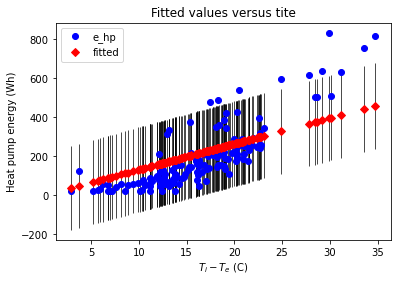

In [5]:
# Choosing output and inputs
y = df['e_hp']
x = df[['tite']]

# Model fitting
res = sm.OLS(endog=y, exog=x).fit()

# Summary of the results in a table
print(res.summary())

# Scatter plot of the fitted model
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res, 0, ax=ax)
ax.set_ylabel('Heat pump energy (Wh)')
ax.set_xlabel('$T_i - T_e$ (C)')
plt.show()

The table displays the results of the linear regression fitting by ordinary least squares. Some indicators are useful to judge if the model sufficiently explains the output data, or if some input features are redundant.
* The t-statistic and p-value indicate whether an input has a significant influence on the input: `P>|t|` should be close to zero, meaning that the null hypothesis should be rejected. In this case, the only input is relevant.
* R-squared measures the goodness of fit of the regression. 0.817 is a rather low value, which hints that the output should be explained by additional features in the model.
* AIC and BIC will be used to compare several models. A lower value is preferred.
* A low Durbin-Watson statistic suggests a high autocorrelation of residuals, which means that the model structure is inappropriate.

The plot confirms that the data is not solely explained by a linear function of $(T_i-T_e)$, and the model should be improved.

### Complete model

Now we can try a more complete linear regression model, which matches the full model described earlier

$$ e_{hp} = a_1 (T_i-T_e) + a_2 (T_i-T_g) + a_3 I_{sol} + a_4 (T_i-T_s) + a_4 V_{ws}(T_i-T_e) $$

This model has five inputs, which we defined as functions of the columns of the original dataset.

In [6]:
# Model definition and fitting
y = df['e_hp']
x = df[['tite', 'titg', 'i_sol', 'tits', 'vtite']]
res = sm.OLS(endog=y, exog=x).fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                   e_hp   R-squared (uncentered):                   0.866
Model:                            OLS   Adj. R-squared (uncentered):              0.861
Method:                 Least Squares   F-statistic:                              188.0
Date:                Thu, 26 Aug 2021   Prob (F-statistic):                    9.27e-62
Time:                        06:52:58   Log-Likelihood:                         -899.88
No. Observations:                 151   AIC:                                      1810.
Df Residuals:                     146   BIC:                                      1825.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The R-squared has improved, and the AIC and BIC criteria have decreased: this model seems to be a better choice than the first one.

Two input variables however have a very high $p$-value: $(T_i-T_g)$ and $V_{ws}(T_i-T_e)$. This suggests that the heat transfer between the heated space and the garage, and the wind, have little impact on the energy consumption of the heat pump. We can simplify the model by removing these two features:

                                 OLS Regression Results                                
Dep. Variable:                   e_hp   R-squared (uncentered):                   0.866
Model:                            OLS   Adj. R-squared (uncentered):              0.863
Method:                 Least Squares   F-statistic:                              317.5
Date:                Thu, 26 Aug 2021   Prob (F-statistic):                    3.04e-64
Time:                        06:52:58   Log-Likelihood:                         -899.93
No. Observations:                 151   AIC:                                      1806.
Df Residuals:                     148   BIC:                                      1815.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

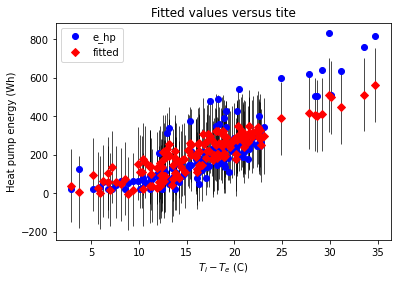

In [7]:
y = df['e_hp']
x = df[['tite', 'i_sol', 'tits']]
res = sm.OLS(endog=y, exog=x).fit()
print(res.summary())

# Scatter plot of the fitted model
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res, 0, ax=ax)
ax.set_ylabel('Heat pump energy (Wh)')
ax.set_xlabel('$T_i - T_e$ (C)')
plt.show()

With less dimensions, the AIC and BIC criteria have decreased. Furthermore, the R-squared was not impacted by the removal of two features, suggesting that they were indeed not influential.

This model seems to be a decent compromise, although some influences still appear to be missing.

### Adding features

The first equation shown above includes the influences that we assumed the most relevant to the energy consumption of the heat pump. The data may contain some additional explanatory variables, which may help predict $e_{hp}$ outside of this formalisation. For instance, the energy for DHW production $e_{dhw}$ and other uses $e_{other}$ indicate occupancy, which could be correlated to $e_{hp}$.

                                 OLS Regression Results                                
Dep. Variable:                   e_hp   R-squared (uncentered):                   0.909
Model:                            OLS   Adj. R-squared (uncentered):              0.906
Method:                 Least Squares   F-statistic:                              292.1
Date:                Thu, 26 Aug 2021   Prob (F-statistic):                    3.87e-74
Time:                        06:52:59   Log-Likelihood:                         -870.33
No. Observations:                 151   AIC:                                      1751.
Df Residuals:                     146   BIC:                                      1766.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

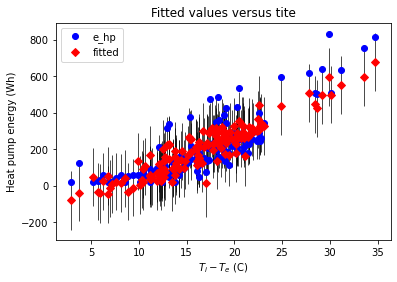

In [8]:
y = df['e_hp']
x = df[['tite', 'titg', 'tits', 'e_dhw', 'e_other']]
res = sm.OLS(endog=y, exog=x).fit()
print(res.summary())

# Scatter plot of the fitted model
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res, 0, ax=ax)
ax.set_ylabel('Heat pump energy (Wh)')
ax.set_xlabel('$T_i - T_e$ (C)')
plt.show()

Using the same indicators as before, it seems that the model has been improved again.

As a further improvement, we could suggest using qualitative features such as the day of the week. The energy signature notebook shows that in some buildings, this information is very relevant on the energy use. This building is however a house, with probably less difference between week days and week ends than in office buildings.